---
## MFE 409: Financial Risk Management Problem set 3 - Group 8 Cohort 1
## Individual Writeup by - Vikalp Thukral
---

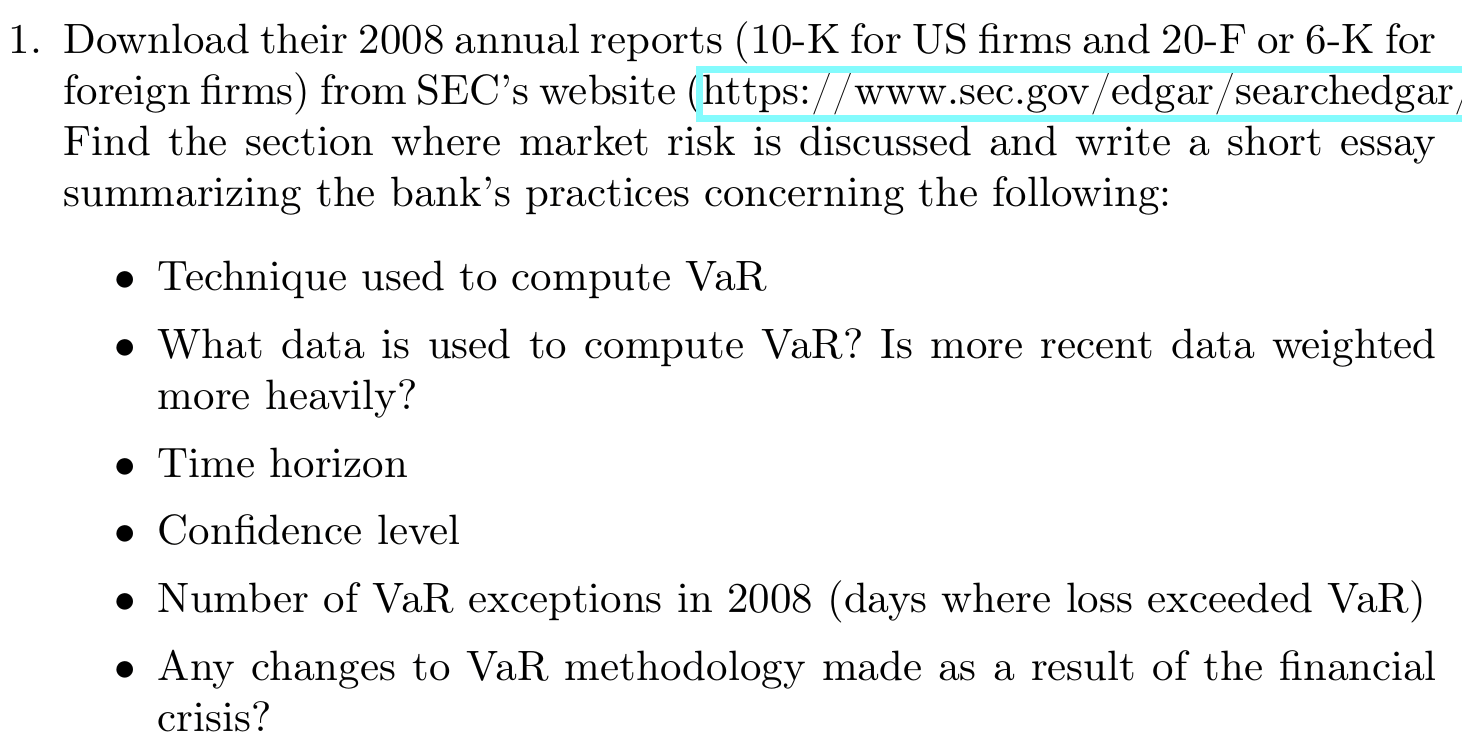

### <b>1.</b>1 Bank of America VaR practices in Financial Year 2008

According to my Group Number, the bank for this question is Bank of America.

---

### Technique used to Compute VaR

Bank of America uses a **Value-at-Risk (VaR)** model based on the *historical simulation* approach. This method simulates portfolio value under a range of hypothetical scenarios derived from **three years** of historical data to produce a distribution of potential gains and losses

---
### What data is used to compute VaR? Is more recent data weighted more heavily?

- The VaR model utilizes **three years of historical market data**.
- Originally, historical data was updated quarterly, but due to the financial crisis and extreme market volatility, starting in Q1 2008, **the data update frequency was increased to a weekly basis**, making the model more responsive to current market conditions.
- However, the historical simulation technique itself **does not explicitly weight recent data more heavily**

---
### Time horizon

The Historical model assumes **a one-day time horizon** for VaR calculations. That is it estimates the worst expected loss over the next trading day, given current market conditions. 

---
### Confidence level

The historical simulation VaR model uses **99% confidence level**. That is Bank of America predicts what is the worst loss that can occur in the next one day with 1% probability. Statistically it means that, if the model is robust, the daily losses exceed the predicted VaR 1 in every 100 trading days, or 2-3 times every financial year (***Expected**** expectations are 2.52)

---
### Number of VaR exceptions in 2008

- In 2008, actual losses exceeded the daily trading VaR **only 2 times**, excluding any discrete writedowns on Collateralized Debt Obligations (CDOs).

- In contrast, 2007 saw 14 such exceptions (again excluding discrete CDO writedowns)

---
### Any changes to VaR methodology made as a result of the financial crisis?

- The model **frequency** for refreshing historical data was changed from **quarterly to weekly**.
- Increased emphasis on Backtesting the VaR Model (since 2007 had a lot of exceptions due to the beginning of GFC)
- Bank of America also stress test their trading strategies and portfolio for those 1% cases where losses can exceed VaR from abnormal market momements in periods of stress.


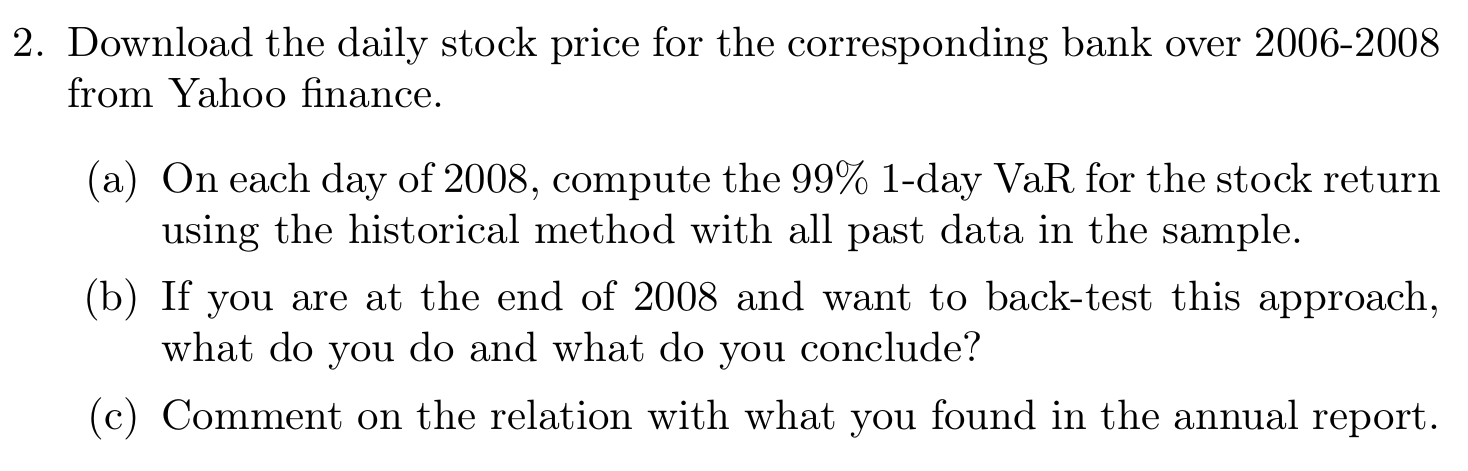

### <b>1.</b>2(a) Calculating VaR for the Bank's stock for the Financial Year 2008
---


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('BAC', start='2006-01-01', end='2008-12-31')
price = data['Close']['BAC']
returns = np.log(price / price.shift(1)).dropna()
returns.name = "LogReturn"

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


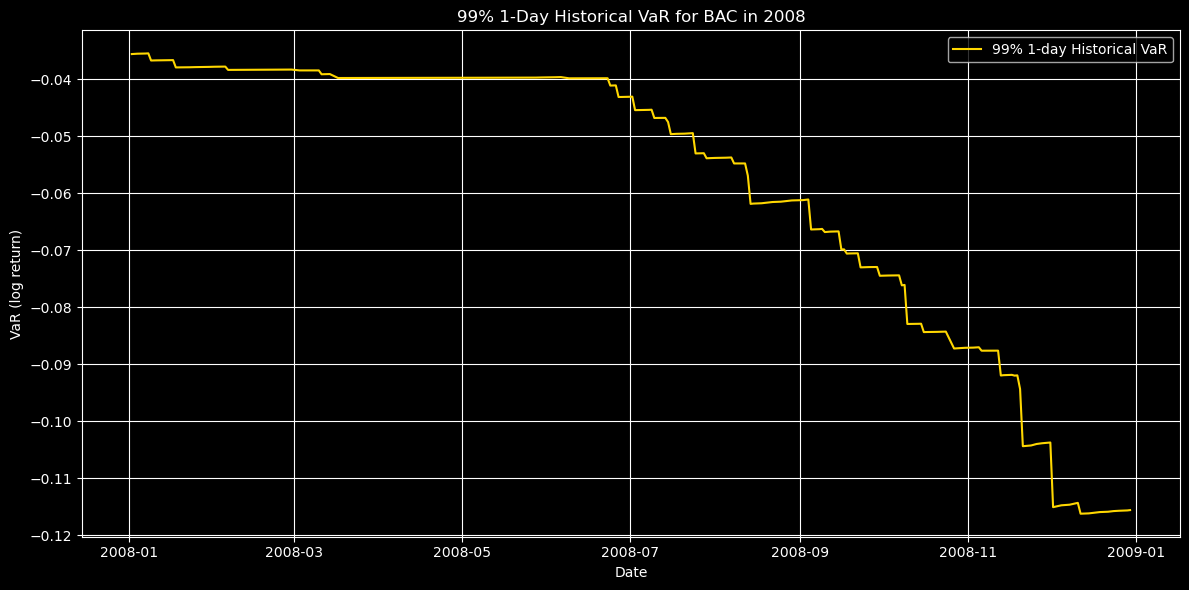

In [2]:
var_99 = []
dates_2008 = returns[returns.index.year == 2008].index
for dates in dates_2008:
    past_data = returns[returns.index < dates]
    var = np.percentile(past_data, 1) # 1% Percentile
    var_99.append(var)

var_df = pd.DataFrame({
    'Date': dates_2008,
    '99% 1-day Historical VaR': var_99
})
var_df.set_index('Date', inplace=True)
plt.style.use('dark_background')  
plt.figure(figsize=(12, 6))
plt.plot(var_df, label='99% 1-day Historical VaR', color='gold')
plt.title('99% 1-Day Historical VaR for BAC in 2008')
plt.ylabel('VaR (log return)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
    
    

### <b>1.</b>2(b) Backtesting the VaR on 2008 Data
---


In [3]:
actual_returns_2008 = returns[returns.index.year == 2008]
var_series = pd.Series(var_99, index=dates_2008)
exceptions = actual_returns_2008 < var_series
num_exceptions = exceptions.sum()

print(f"Number of VaR exceptions in 2008: {num_exceptions}")
print(f"Expected number under 99% confidence: {len(actual_returns_2008) * 0.01:.2f}")

Number of VaR exceptions in 2008: 31
Expected number under 99% confidence: 2.52


##  Hypothesis Test Setup

We assume:

- **252 trading days in 2008**
- Model predicts a **99% confidence level**, so:
  - Probability of exception \( p = 0.01 \)
  - Expected number of exceptions = \( n \cdot p = 252 \cdot 0.01 = 2.52 \)

---

##  Hypotheses

$$
H_0: \quad \text{The VaR model is correctly calibrated, i.e., } X \sim \text{Binomial}(n = 252, p = 0.01)
$$

$$
H_1: \quad \text{The VaR model is miscalibrated, i.e., } p \ne 0.01
$$

This is a **two-tailed test** because both too many and too few exceptions suggest miscalibration.


In [4]:
from scipy.stats import binomtest

n = 252
p = 0.01
observed = 31

result = binomtest(observed, n, p, alternative='two-sided')
print(f"P-value: {result.pvalue:.5f}")


P-value: 0.00000


- Since P-value is way less than $\alpha = 0.05$, we reject the Null Hypothesis
- The model is severely miscalibrated - which is to be expected, since the markets during 2006 and early 2007 is vastly different from the markets during GFC and relying on that historical data will give a miscallibrated model unless some stress testing and revisions are made to account for extreme and abnormal market conditions
---

### <b>1.</b>2(c) Relation of Backtested Results with Annual Report 10-K
---


The 99% 1-day VaR we computed was based solely on **Bank of America’s daily stock returns**, representing the equity risk of a single asset. Our backtest for 2008 resulted in **31 VaR exceptions**, which is significantly higher than the expected ~2.5 exceptions for a correctly calibrated 99% VaR model. This indicates that the historical VaR approach **severely underestimated the risk** of extreme losses during the financial crisis.

In contrast, Bank of America’s **2008 10-K annual report** discusses VaR in the context of the firm’s **diversified trading portfolio**, which includes multiple asset classes across various business lines, often with hedges in place. Their reported number of VaR exceptions in 2008 was **only 2**, using a similar 99% confidence level and 1-day horizon. However, they also acknowledged the **limitations of VaR** in stressed conditions and described enhancements such as:
- Increasing the **data update frequency** from quarterly to weekly,
- Greater reliance on **stress testing**, and
- Use of **desk-level risk limits**.

### Interpretation

While the **number of exceptions** differs due to the **difference in scope** — individual stock vs. full trading book — the **underlying message is consistent**:
> **VaR models alone were insufficient during the 2008 crisis**, and banks like BofA had to supplement them with broader risk management practices.

This validates our findings and illustrates why risk measures need to evolve in volatile market environments.


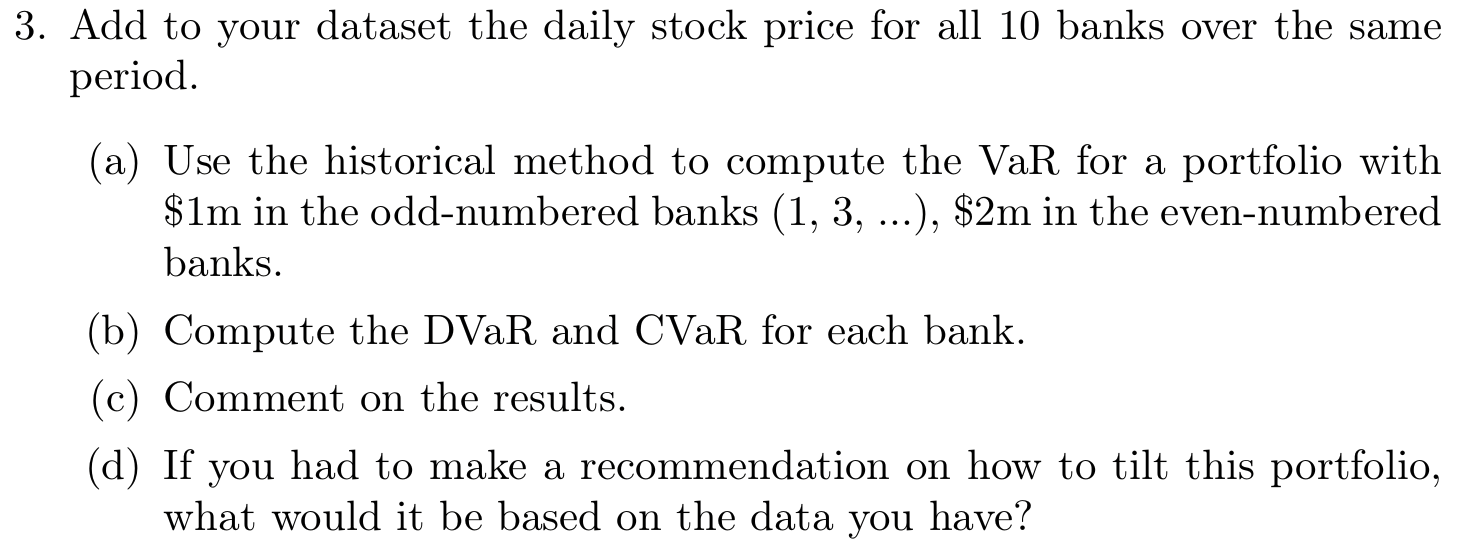

---
### <b>1.</b>3(a) Calculating VaR for the given Bank Portfolio
---

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = {
    1: 'GS',
    2: 'UBS',
    3: 'JPM',
    4: 'C',
    5: 'BCS',
    6: 'MS',
    7: 'DB',
    8: 'BAC',
    9: 'BNPQY'
}

data_yahoo = yf.download(list(tickers.values()), start='2006-01-01', end='2008-12-31')
close_prices = data_yahoo['Close']
returns_yahoo = np.log(close_prices / close_prices.shift(1)).dropna()
cs_data = pd.read_csv("CS.csv")
# Downloaded Credit Suisse Data from WRDS since it was delisted from Yahoo Finance
cs_data['date'] = pd.to_datetime(cs_data['date'])
cs_data.set_index('date', inplace=True)
cs_data = cs_data[cs_data['PRC'].notnull() & (cs_data['PRC'] > 0)]
cs_prices = cs_data[['PRC']].copy()
returns_cs = np.log(cs_prices / cs_prices.shift(1)).dropna()
returns_cs = returns_cs.sort_index()
returns_cs.columns = ['CS']
returns_combined = returns_yahoo.join(returns_cs, how='inner')
returns_combined.head()


[*********************100%***********************]  9 of 9 completed


,BAC,BCS,BNPQY,C,DB,GS,JPM,MS,UBS,CS
2006-01-04,-0.010676,0.011635,0.023698,-0.018635,0.018923,-0.013909,-0.005789,0.000685,0.019165,0.022977
2006-01-05,0.001287,-0.007970,-0.004695,0.004949,-0.004747,-0.000394,0.003025,0.002738,0.002878,0.001098
2006-01-06,-0.001502,0.017900,0.005865,0.000000,0.018464,0.014069,0.007021,0.001025,0.020888,0.021004
2006-01-09,0.000644,-0.003149,0.009313,-0.004742,-0.004877,0.011959,0.016112,0.010530,-0.003792,0.001253
2006-01-10,-0.008404,-0.013837,-0.003482,0.003095,0.001466,0.012499,0.001474,0.000507,-0.006156,-0.008988


In [6]:
ordered_tickers = ['GS', 'UBS', 'JPM', 'C', 'BCS', 'MS', 'DB', 'BAC', 'BNPQY', 'CS']


weights = {}
for i, ticker in enumerate(ordered_tickers):
    weights[ticker] = 1 if (i + 1) % 2 == 1 else 2

weights_series = pd.Series(weights)
weights_series /= weights_series.sum()  # Normalize weights


returns_ordered = returns_combined[ordered_tickers]


portfolio_returns = returns_ordered.dot(weights_series)


var_99 = np.percentile(portfolio_returns, 1)
cvar_99 = portfolio_returns[portfolio_returns <= var_99].mean()
print(f'Portfolio 99% VaR: {var_99*(-100):.2f}%, Portfolio 99% ES: {cvar_99*(-100):.2f}%')

Portfolio 99% VaR: 12.61%, Portfolio 99% ES: 15.70%


---
### <b>1.</b>3(b) Calculating C-VaR & DVaR for each bank in the portfolio
---

In [7]:
import numpy as np
import pandas as pd

returns = returns_combined.copy()
tickers_ordered = ['GS', 'UBS', 'JPM', 'C', 'BCS', 'MS', 'DB', 'BAC', 'BNPQY', 'CS']
positions = np.array([1_000_000 if i % 2 == 0 else 2_000_000 for i in range(10)])
weights = pd.Series(positions, index=tickers_ordered)

returns = returns[tickers_ordered]
portfolio_returns = returns.dot(weights)
var_level = 1
portfolio_var = np.percentile(portfolio_returns, var_level)

bump_size = 1.0
dvar = {}
for i, ticker in enumerate(tickers_ordered):
    bumped_weights = weights.copy()
    bumped_weights[ticker] += bump_size
    bumped_portfolio_returns = returns.dot(bumped_weights)
    bumped_var = np.percentile(bumped_portfolio_returns, var_level)
    dvar[ticker] = (bumped_var - portfolio_var) / bump_size

dvar_series = pd.Series(dvar)
cvar_series = weights * dvar_series
total_cvar = cvar_series.sum()

results = pd.DataFrame({
    'Position ($)': weights,
    'DVaR': dvar_series,
    'CVaR': cvar_series
})

results.loc['Total'] = [weights.sum(), np.nan, total_cvar]
results['DVaR'] = results['DVaR'].astype(float).map(lambda x: f"{x * 100:.2f}%")
results['CVaR'] = results['CVaR'].astype(float).map(lambda x: f"{x:,.0f}")
results['Position ($)'] = results['Position ($)'].astype(float).map(lambda x: f"{x:,.0f}")
results.head(11)


,Position ($),DVaR,CVaR
GS,"1,000,000",-11.49%,"-114,909"
UBS,"2,000,000",-14.34%,"-286,791"
JPM,"1,000,000",-9.16%,"-91,607"
C,"2,000,000",-12.69%,"-253,887"
BCS,"1,000,000",-2.10%,"-20,989"
MS,"2,000,000",-22.58%,"-451,687"
DB,"1,000,000",-14.20%,"-141,963"
BAC,"2,000,000",-9.58%,"-191,612"
BNPQY,"1,000,000",-8.80%,"-87,962"
CS,"2,000,000",-12.50%,"-249,924"


> **Note:**  
> Since Credit Suisse was delisted from NYSE, its historical data was removed from Yahoo Finance as well.  
> I have used WRDS CRSP data to account for that.

---

### <b>1.</b>3(c) Comment on the results

The portfolio has a **99% Expected Shortfall (ES)** of **15.70%**, which corresponds to a dollar loss of approximately **$1,891,331** on a $15 million portfolio in the worst 1% of cases. This reflects significant tail risk.

Analyzing the **Component VaR (CVaR)**:

- The largest contributors to risk are:
  - **Morgan Stanley (MS)**: USD 451,687 (~24% of total CVaR)
  - **UBS**: USD 286,790
  - **Citigroup (C)** and **Credit Suisse (CS)**: Each contributing more than USD 250,000

- The smallest contributors are:
  - **Barclays Capital (BCS)** and **BNP Paribas (BNPQY)**, both under USD 100,000

The **Diversified VaR (DVaR)** also shows MS as the riskiest asset in percentage terms at **−22.58%**, while BCS has the lowest at **−2.10%**.

> **Insight:** The portfolio’s risk is heavily concentrated in a few names—particularly MS and UBS—despite being diversified across ten banks.

---

### <b>1.</b>3(d) Recommendation on how to tilt the portfolio

To reduce portfolio tail risk (as measured by CVaR):

- **Reduce exposure** to the most risk-contributing banks:
  - **Morgan Stanley (MS)**, **UBS**, and **Citigroup (C)**

- **Increase allocation** to banks with lower CVaR and DVaR:
  - **Barclays (BCS)**, **BNP Paribas (BNPQY)**, and **BAC**

- Consider a more **balanced or volatility-weighted allocation** to avoid risk concentration

> **Conclusion:**  
> If the goal is to reduce downside risk, the portfolio should be tilted away from high-risk contributors like MS and UBS and toward lower-risk positions like BCS and BNPQY. This improves stability while maintaining diversification.
---


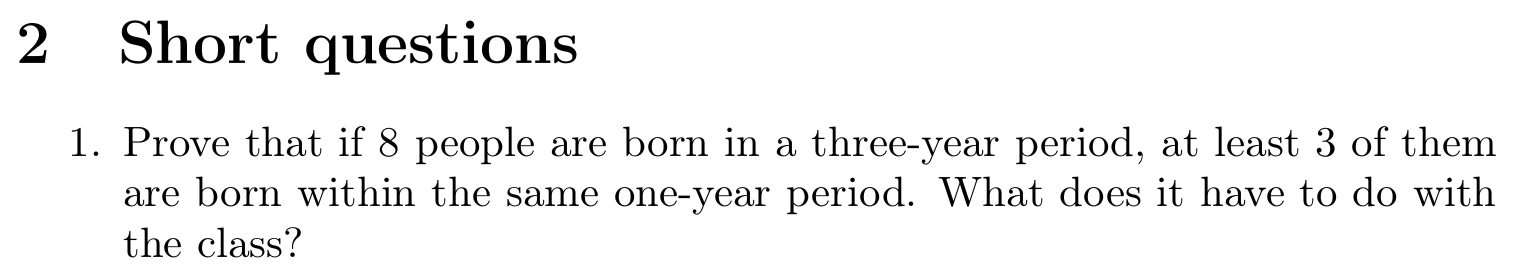

---
### <b>2.</b>1
---

#### Proof by Contradiction

Suppose that **no 3 people are born within the same one-year period**.

Let the dates of birth (in increasing order) be:  
`d₁, d₂, d₃, d₄, d₅, d₆, d₇, d₈` where `d₁` is the oldest and `d₈` the youngest.

We are told:  
```
time(d₁ − d₈) ≤ 3
```

But our assumption implies:
- time(d₁ − d₃) > 1        … (i)  
- time(d₂ − d₄) > 1        … (ii)  
- time(d₃ − d₅) > 1        … (iii)  
- time(d₄ − d₆) > 1        … (iv)  
- time(d₅ − d₇) > 1        … (v)  
- time(d₆ − d₈) > 1        … (vi)

Adding (i), (iii), and (v):
```
time(d₁ − d₃) + time(d₃ − d₅) + time(d₅ − d₇) > 3
⇒ time(d₁ − d₇) > 3
⇒ time(d₁ − d₈) > 3    (since d₈ ≥ d₇)
```

But this contradicts the fact that `d₁ − d₈ ≤ 3`.  
Therefore, our assumption is incorrect.

**⇒ At least 3 people must be born within the same 1-year period.**

---

#### Proof Using the Pigeonhole Principle

There are only **3 one-year periods** in any 3-year span.  
To avoid placing 3 people in the same year, we can place at most:
```
2 people/year × 3 years = 6 people
```

But we are given **8 people**, which is more than 6.

Hence, by the **Pigeonhole Principle**, **at least 3 people must be born in the same one-year period**.

---

####  Connection to the Class

This resembles **Value-at-Risk (VaR) backtesting** in risk management.  
In a 99% VaR model, we expect about 1% of days to breach the threshold.  
If **too many exceptions** occur, it implies the model is **misspecified**.

Just like too many people in a short time frame breaks the birthday assumption,  
**too many VaR breaches break the risk model assumption.**

** Both rely on the logic that exceeding expected limits implies invalid assumptions.**


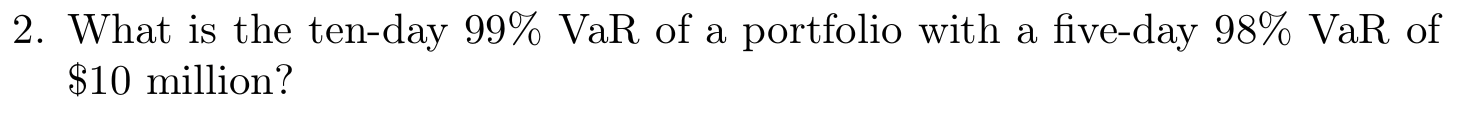

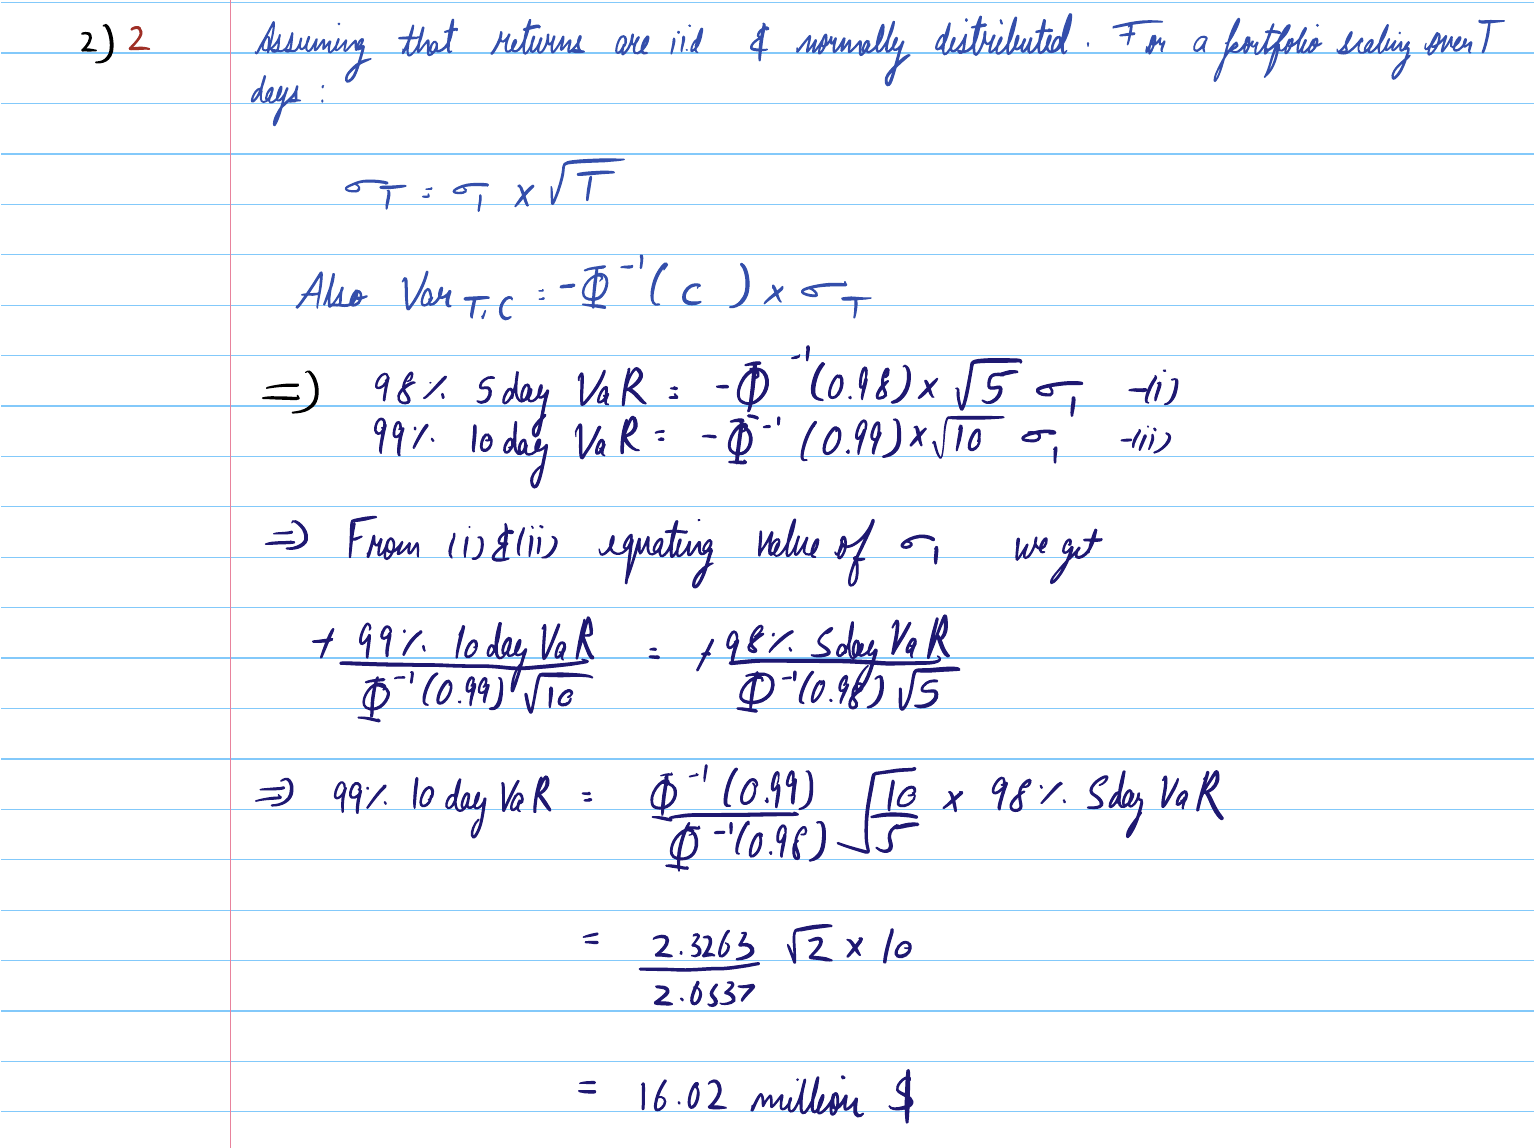


---


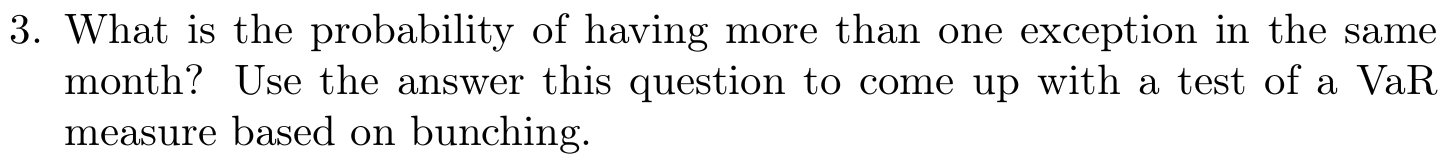

### <b>2.</b>3

We assume that the daily VaR is calibrated at 99%, meaning the probability of a VaR exception (loss exceeding VaR) on any given day is $p = 0.01$.

Assuming there are 21 trading days in a month, the number of exceptions in a month follows a **Binomial distribution**:

$$
X \sim \text{Binomial}(n = 21, p = 0.01)
$$

We are interested in the probability of observing **more than one exception** in a month:

$$
P(X \geq 2) = 1 - P(X = 0) - P(X = 1)
$$

Using the binomial formula:

$$
P(X = 0) = (1 - p)^{21} = 0.99^{21} \approx 0.809
$$

$$
P(X = 1) = \binom{21}{1} \cdot 0.01 \cdot 0.99^{20} \approx 21 \cdot 0.01 \cdot 0.8179 \approx 0.172
$$

$$
P(X \geq 2) = 1 - 0.809 - 0.172 = 0.019
$$

### Therefore, the probability of having more than one exception in a month is approximately **1.9%**.

---

### VaR Model Test Based on Bunching

If the **model is correctly calibrated**, we expect to see **more than one exception in a month only 1.9% of the time**. Therefore, **frequent months with multiple exceptions** indicate **VaR underestimation** and model misspecification.

#### Bunching Test Idea:
1. Count how many months have **2 or more exceptions**.
2. Compare this number to the expected number under the binomial model (1.9% of months).
3. If the actual frequency is **significantly higher**, reject the null hypothesis that the VaR model is well-calibrated.

This test focuses on the **clustering of exceptions**, a phenomenon that arises when the VaR model **fails to capture fat tails or time-varying volatility** in returns.


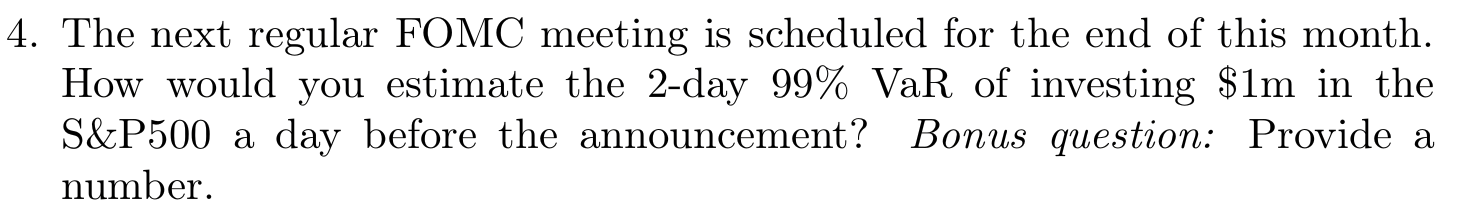

### 4. Estimating 2-Day 99% VaR Around FOMC Announcement

To estimate the **2-day 99% VaR of investing \$1 million in the S&P500 a day before the FOMC meeting**, we proceed as follows:

---

####  Methodology:

1. **Historical Approach**:
   - Identify **previous FOMC announcement dates** (available via Federal Reserve’s official calendar).
   - For each FOMC date, calculate the **2-day return**:
     - One day before and the day of the announcement.
   - Compute the empirical **1st percentile** of these 2-day returns.

2. **Volatility Scaling Approach**:
   - Estimate **daily volatility** of S&P500 in a recent window (e.g., past 30–60 days).
   - Apply a **volatility bump-up factor** based on prior FOMC event windows (typically 1.5× to 2× normal volatility).
   - Scale it to 2-day VaR:
     $$
     \text{VaR}_{99\%,2d} = z_{0.99} \cdot \sigma_{\text{event}} \cdot \sqrt{2} \cdot \text{Portfolio Value}
     $$

---

####  Bonus: Estimate

---


In [8]:
import pandas as pd
import numpy as np
import yfinance as yf


fomc_dates = pd.to_datetime([
    "2024-01-31", "2024-03-20", "2024-05-01", "2024-06-12", 
    "2024-07-31", "2024-09-18", "2024-11-07", "2024-12-18",
    "2025-01-29", "2025-03-19"
])


sp500 = yf.download("^GSPC", start="2023-12-01", end="2025-04-01", group_by='column')


sp500['Return'] = np.log(sp500[('Close', '^GSPC')] / sp500[('Close', '^GSPC')].shift(1))


sp500['FOMC'] = sp500.index.isin(fomc_dates)


fomc_vol = sp500[sp500['FOMC']]['Return'].std()
non_fomc_vol = sp500[~sp500['FOMC']]['Return'].std()
relative_sigma = fomc_vol / non_fomc_vol

print(f"Volatility on FOMC days: {fomc_vol:.5f}")
print(f"Volatility on non-FOMC days: {non_fomc_vol:.5f}")
print(f"Relative sigma event (FOMC / non-FOMC): {relative_sigma:.2f}")


[*********************100%***********************]  1 of 1 completed

Volatility on FOMC days: 0.01400
Volatility on non-FOMC days: 0.00817
Relative sigma event (FOMC / non-FOMC): 1.71


In [9]:
VAR99 = 2.3263*np.sqrt(2)*fomc_vol*10_000_000
print(f'Assuming a 10 Million$ Portfolio, a 2 day 99% VaR around FOMC meetings is: ${VAR99:,.0f}')

Assuming a 10 Million$ Portfolio, a 2 day 99% VaR around FOMC meetings is: $460,639


###  Final Answer:

The **estimated 2-day 99% VaR** around the FOMC announcement is approximately **\$460,639**
